In [1]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
books = pd.read_csv(r"Datasets/Books.csv", delimiter=';', on_bad_lines= 'warn', encoding='ISO-8859-1')
users = pd.read_csv(r"Datasets/Users.csv", delimiter=';', on_bad_lines= 'warn', encoding='ISO-8859-1')
ratings = pd.read_csv(r"Datasets/Book-Ratings.csv", delimiter=';', on_bad_lines= 'warn', encoding='ISO-8859-1')

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-Ratings: ", ratings.shape)

Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9



Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-Ratings:  (1149780, 3)


# DATA CLEANING 

## Cleaning of Data for Books 

In [3]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
## Dropping URL Columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [5]:
## Check for the null values
books.isnull().sum() 

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
dtype: int64

In [6]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [7]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [8]:
## Changing those with null values with other instead
books.at[118033 ,'Book-Author'] = 'Other'
books.at[187689 ,'Book-Author'] = 'Other'

books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [9]:
## Checking for a different content within Year-Of Publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [10]:
pd.set_option('display.max_colwidth', 1)

In [11]:
### Checking the details of the books which had their publisher in the Year-Of-Publication column

In [12]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [13]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [14]:
## Correcting the details and assigning them on their respective column
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [15]:
## Years-of -Publication will be turn into a number format
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [16]:
##Checking of years if all are in numbers
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [17]:
##Replacing the Invalid years with the max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [18]:
## Changing invalid years such as zero and those > 2023 with the max year
books.loc[books['Year-Of-Publication'] > 2023, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [19]:
## The alphabets in the ISBN should be capitalized
books['ISBN'] = books['ISBN'].str.upper()

In [20]:
##Duplicate entries or rows is to be dropped
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [21]:
##Check the current info within the Books Data
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int32 
 4   Publisher            271047 non-null  object
dtypes: int32(1), object(4)
memory usage: 9.3+ MB


In [22]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


##  Cleaning Data for Users

In [23]:
##Check the current Users data set
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [24]:
##Null values for each column should be checked
print(users.isna().sum())

User-ID     0     
Location    0     
Age         110762
dtype: int64


In [25]:
##Check what age is present on the age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [26]:
##Setting the age on a valid range of 10-80 and the age out of the said range will be changed to the mean of those who are in the valid range


In [27]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]

In [28]:
mean = round(required['Age'].mean())   
mean

35

In [29]:
users.loc[users['Age'] > 80, 'Age'] = mean    #those with age grater than 80
users.loc[users['Age'] < 10, 'Age'] = mean    #those with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

In [30]:
##Spliting the Location column into 3 separate columns of City, State, and Country
##Setting the empty cells with Other instead.
## The original location column will also be dropped.

list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   #to show the number of countries didnt have any values 
print(count_no_state)     #to show the states which didnt have any values

4659
16044


In [31]:
## Duplicate entries/ rows should also be dropped
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [32]:
## Check the current content of the User data set after cleaning
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int32 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 9.6+ MB


In [33]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


## Cleaning of Book-Ratings Data Set

In [34]:
##Checking the current condition of the data set
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [35]:
## Null values should be checked for each column
ratings.isnull().sum() 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [36]:
## the data type of all ratings should be numbers as well
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [37]:
## The data type of User-ID should be numbers as well
print(is_numeric_dtype(ratings['User-ID']))

True


In [38]:
## Checking for any speacial characters within the ISBN column 
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [39]:
## These extra/special characters needs to removed in the ISBN column for this specific data set
bookISBN = books['ISBN'].tolist() 
reg = "[^A-Za-z0-9]" 
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])    
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [40]:
## Just like the Books data set, the alphabets in ISBN in this data set also needs to be in uppercase
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [41]:
## Duplicate records should also be removed
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [42]:
## Check the current details of the data set after the cleaning process
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [43]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


 # MERGING THE TABLES

 ## Merging all data sets (tables) into one

In [44]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031609 entries, 0 to 1031608
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031609 non-null  object
 1   Book-Title           1031609 non-null  object
 2   Book-Author          1031609 non-null  object
 3   Year-Of-Publication  1031609 non-null  int32 
 4   Publisher            1031609 non-null  object
 5   User-ID              1031609 non-null  int64 
 6   Book-Rating          1031609 non-null  int64 
 7   Age                  1031609 non-null  int32 
 8   City                 1031609 non-null  object
 9   State                1031609 non-null  object
 10  Country              1031609 non-null  object
dtypes: int32(2), int64(2), object(7)
memory usage: 78.7+ MB


## Dividing the merged data into those rated of zero and that of not

In [45]:
## Not equal to zero rating dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384074, 11)

In [46]:
## Equal to zero rating dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647535, 11)

In [47]:
##Check the condition of the data set
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada


In [48]:
dataset2.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0,18,stockton,california,usa
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,8,0,35,timmins,ontario,canada
2,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,8,0,35,timmins,ontario,canada
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,8,0,35,timmins,ontario,canada
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,8,0,35,timmins,ontario,canada


 # DESCRIPTIVE ANALYSIS VISUALIZATION

## Number of Books Published Yearly 

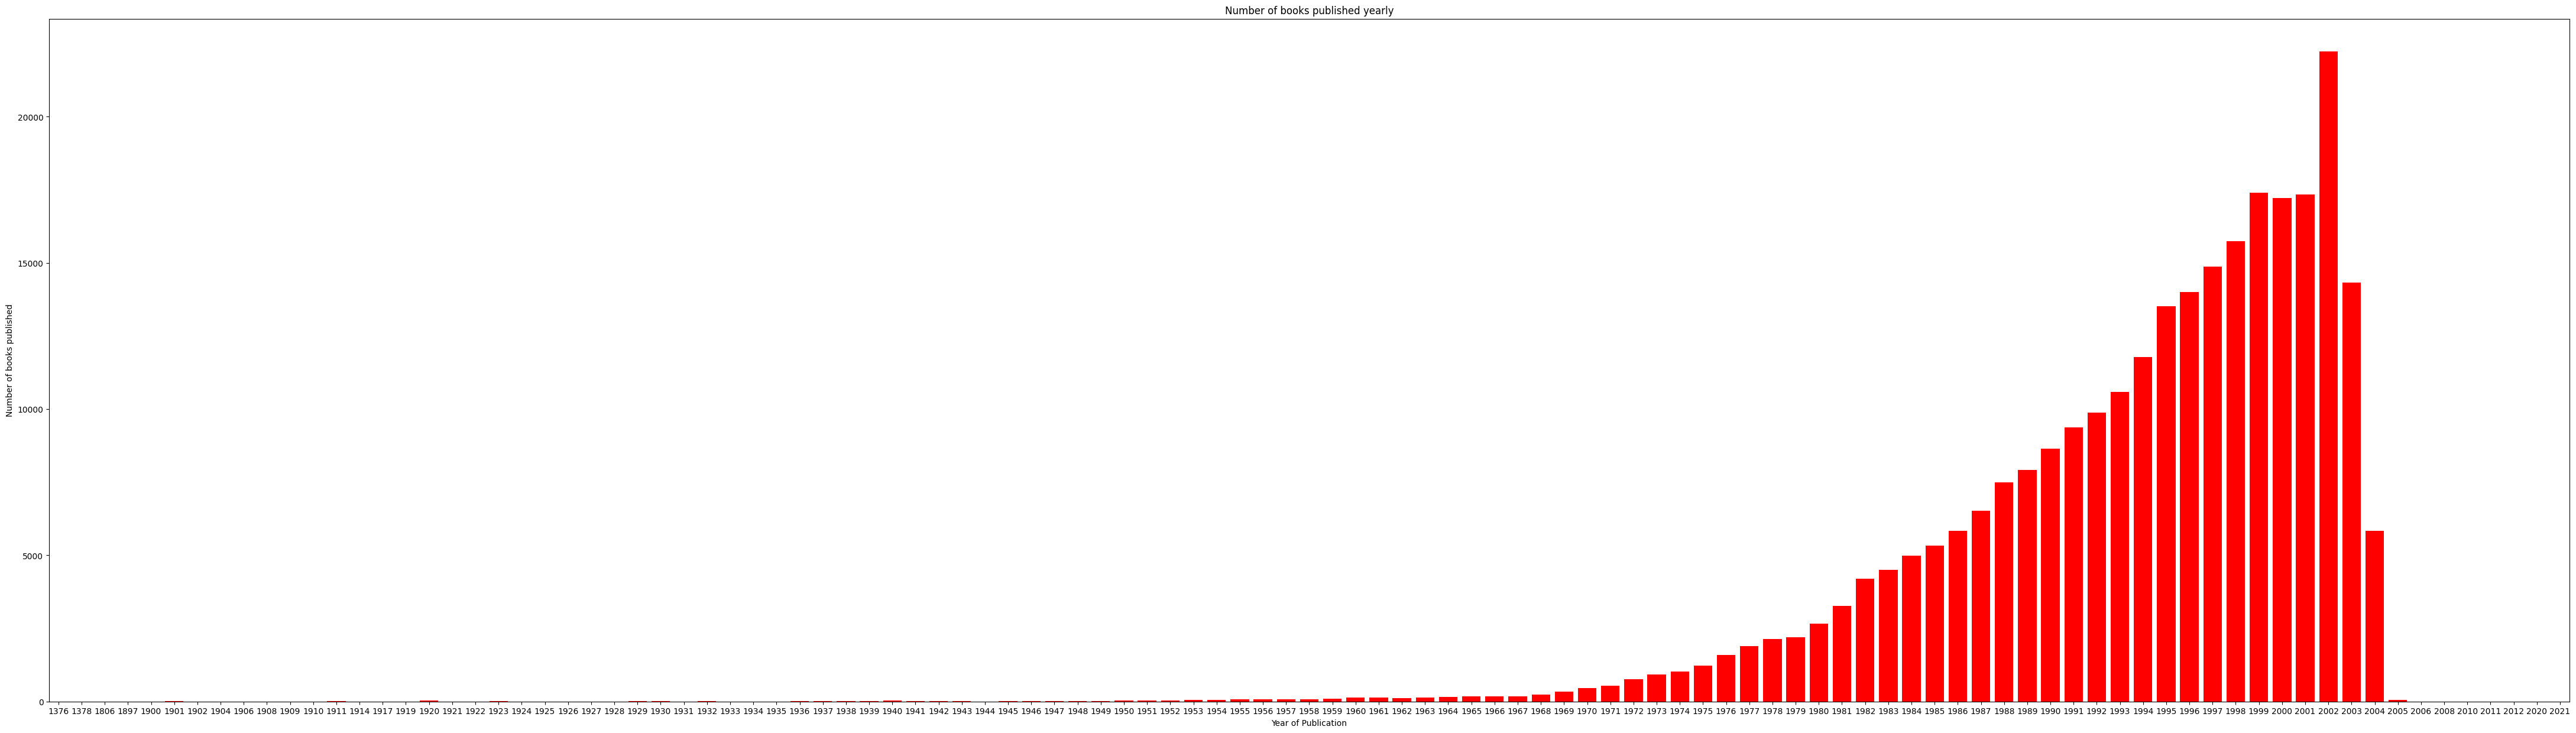

In [49]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'red')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

## Number of Books by an Author (Top 10)  

Text(0.5, 1.0, 'No of books by an author (Top 10)')

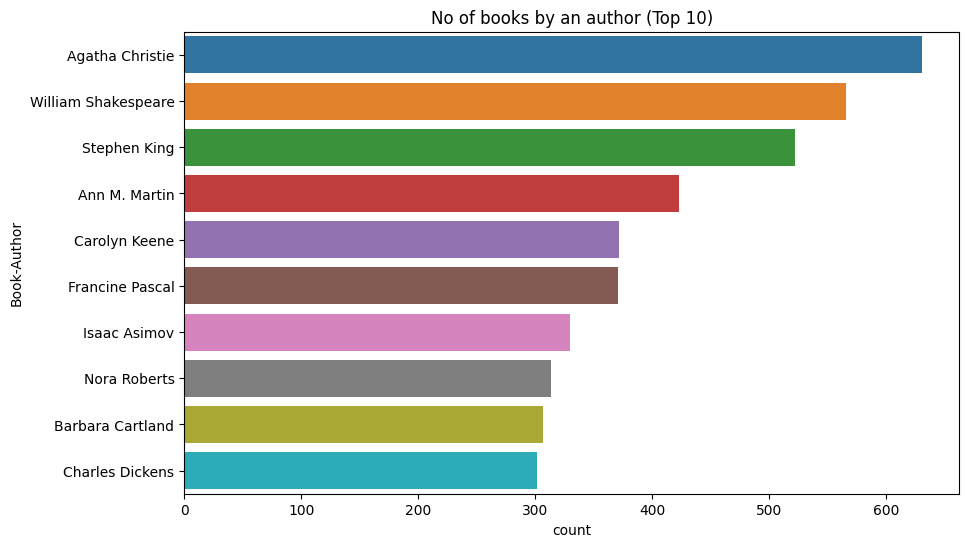

In [50]:
plt.figure(figsize=(10,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:10])
plt.title("No of books by an author (Top 10)")

# Number of Books Published by a  Publisher (Top 10)

Text(0.5, 1.0, 'No of books published by a publisher (Top 10)')

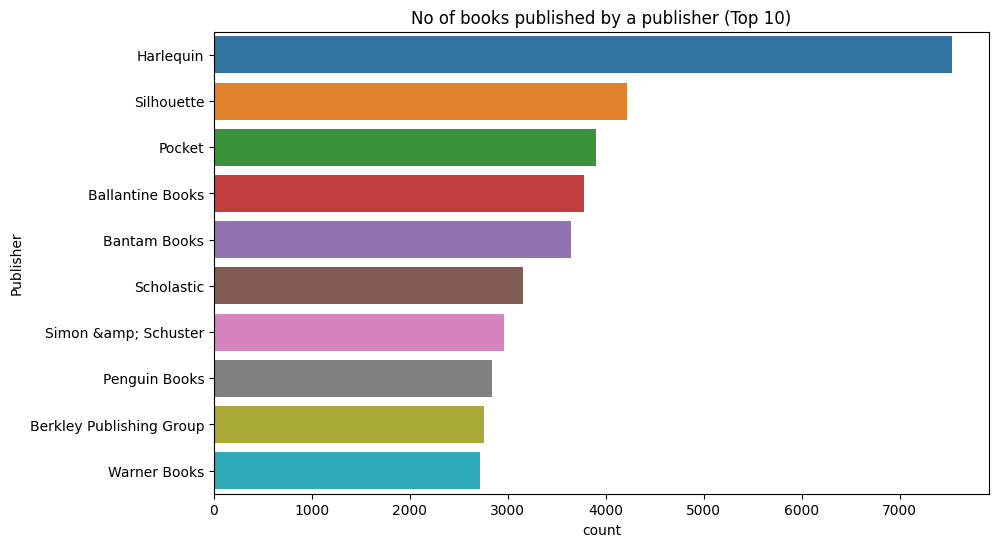

In [51]:
plt.figure(figsize=(10,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:10])
plt.title("No of books published by a publisher (Top 10)")

# Frequency of Rating Occurance : Rates from 0-10

<Axes: xlabel='Book-Rating', ylabel='count'>

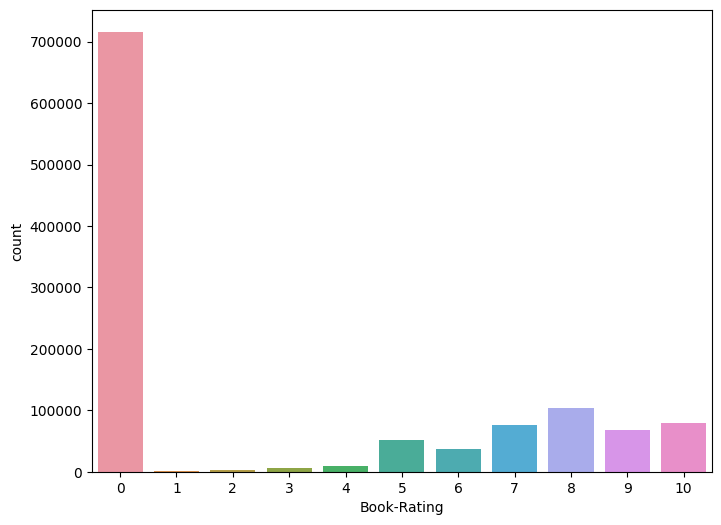

In [53]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

## Frequency of Rating Occurence : Rates Greater than 0 (Explicit Ratings)

Text(0.5, 1.0, 'Explicit Ratings')

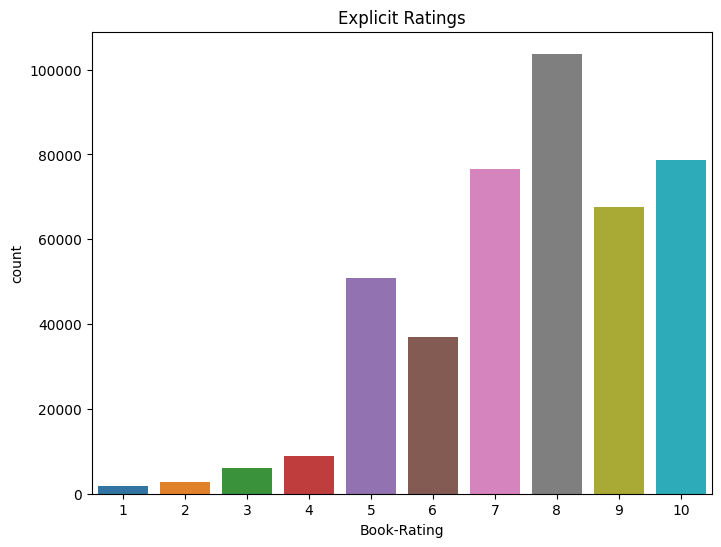

In [54]:
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

## Age Distribution of Users 

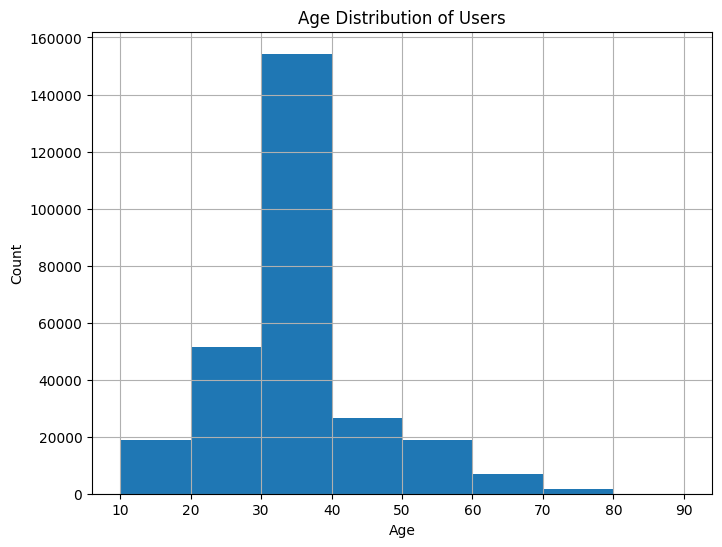

In [55]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

## Number of Reader from each City (Top 10)

Text(0.5, 1.0, 'No of readers from each city (Top 10)')

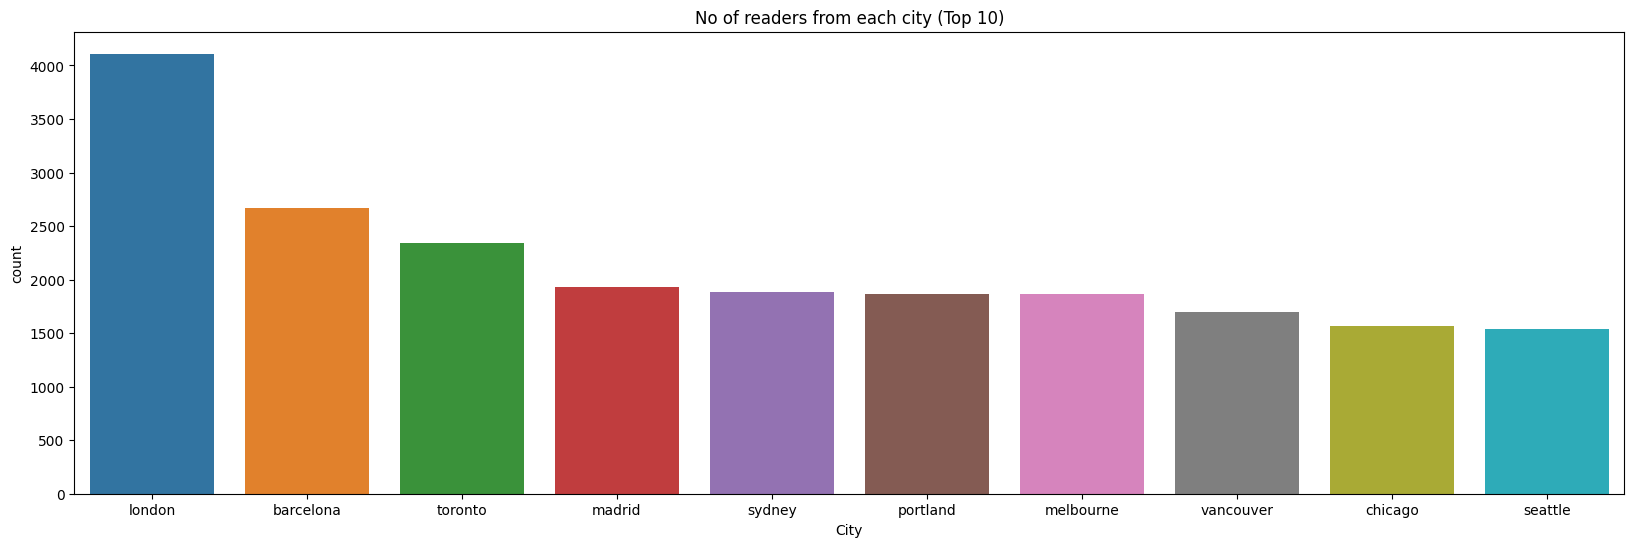

In [56]:
plt.figure(figsize=(20,6))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:10])
plt.title("No of readers from each city (Top 10)")

## Number of Readers from each State (Top 10) 

Text(0.5, 1.0, 'No of readers from each state (Top 10)')

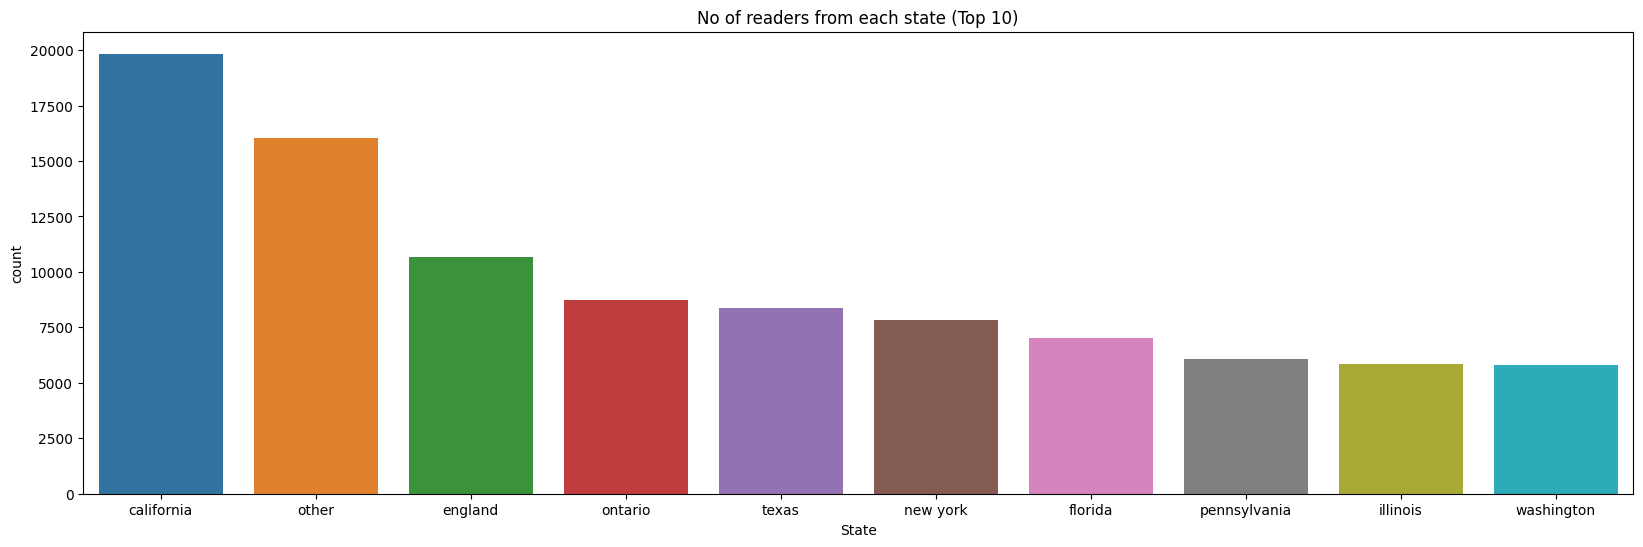

In [57]:
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:10])
plt.title("No of readers from each state (Top 10)")

 ## Number of readers from each Country (Top 10)

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

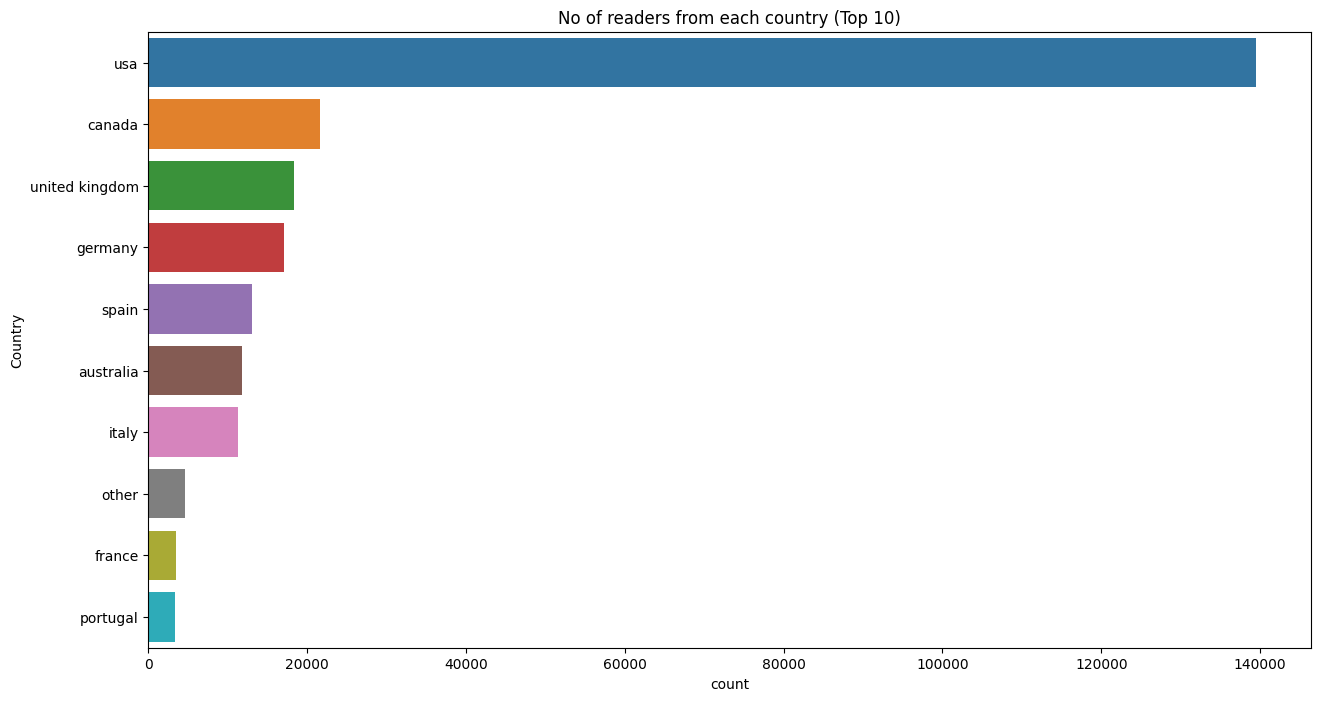

In [58]:
plt.figure(figsize=(15,8))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

## No of readers from states of USA (Top 10)

Text(0.5, 1.0, 'No of readers from states of USA (Top 10)')

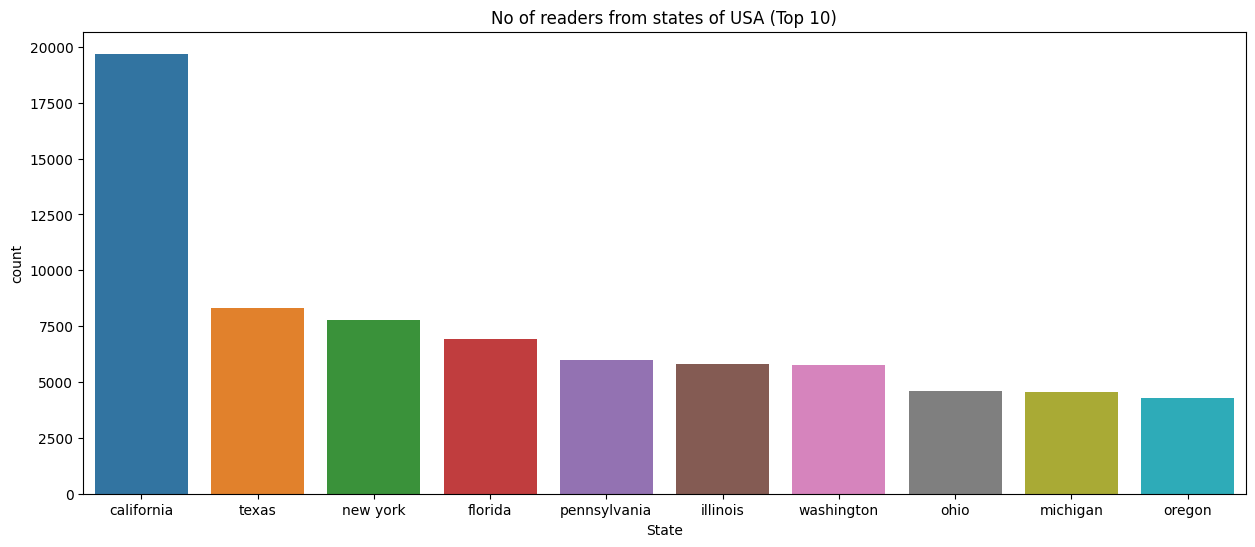

In [59]:
data=users[users['Country']=='usa']
plt.figure(figsize=(15,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:10])
plt.title("No of readers from states of USA (Top 10)")

## Number of Ratings for a book (Top 10)

Text(0.5, 1.0, 'Number of Ratings for a book (Top 10)')

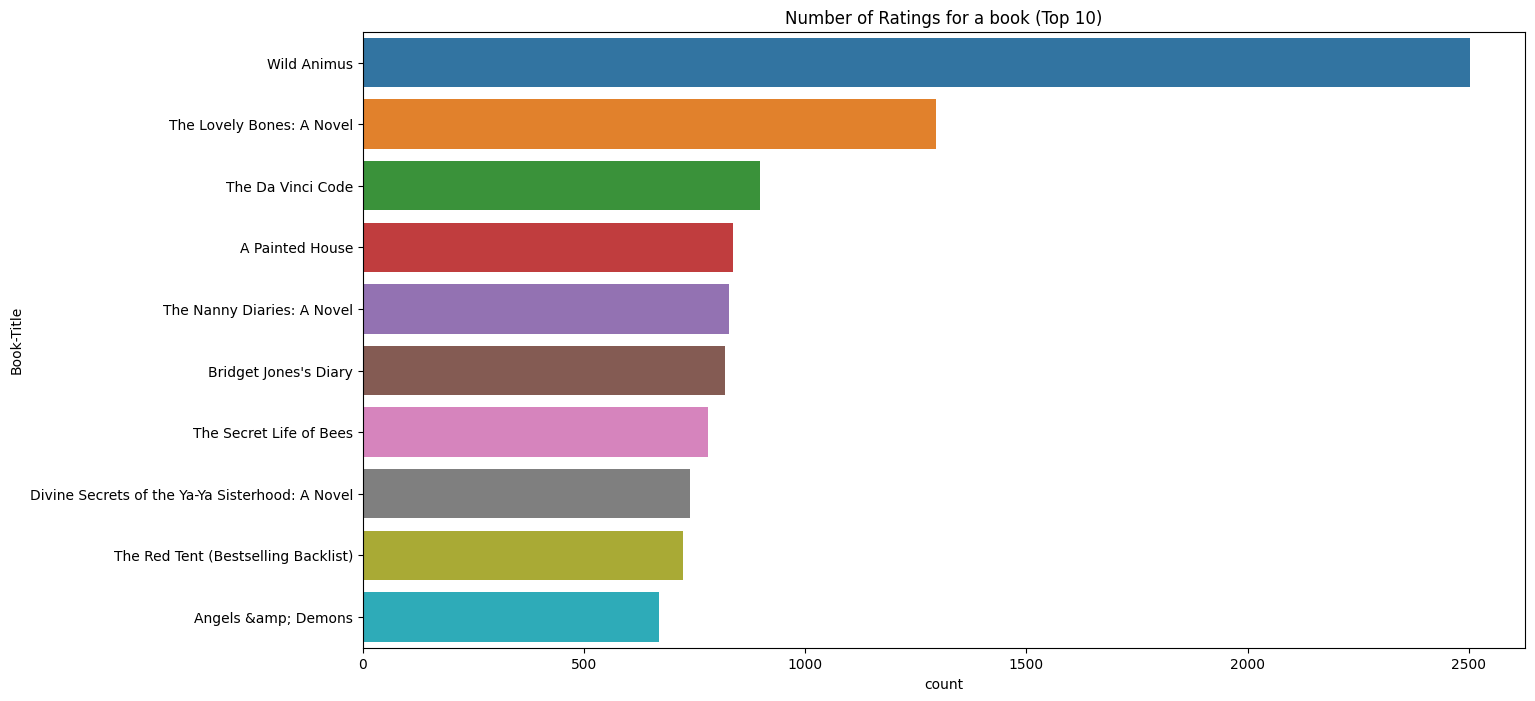

In [60]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:10])
plt.title("Number of Ratings for a book (Top 10)")

# RECOMMENDATION SYSTEMS

In [95]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to recommend: 5


## Popularity Based (Top among the whole collection)

In [66]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        result = pd.merge(data, books, on='ISBN')
        return result
    return "Invalid number of books entered!!"

In [67]:
print("Top", number, "Popular books are: ")
popularity_based(dataset1, number)

Top 5 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,0971880107,581,Wild Animus,Rich Shapero,2004,Too Far
2,0385504209,488,The Da Vinci Code,Dan Brown,2003,Doubleday
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial


 ## Popularity Based (Top in a particular location)

In [71]:
def search_unique_places(dataframe, place):
    place = place.lower()

    if place in list(dataframe['City'].unique()):
        return dataframe[dataframe['City'] == place]
    elif place in list(dataframe['State'].unique()):
        return dataframe[dataframe['State'] == place]
    elif place in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == place]
    else:
        return "Invalid Entry"

In [72]:
place = input("Enter the name of place: ")
data = search_unique_places(dataset1, place)

if isinstance(data, pd.DataFrame):
    data = popularity_based(data, number)

data

Enter the name of place: India


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0971880107,3,Wild Animus,Rich Shapero,2004,Too Far
1,0671047612,2,Skin And Bones,Franklin W. Dixon,2000,Aladdin
2,0486284735,2,Pride and Prejudice (Dover Thrift Editions),Jane Austen,1995,Dover Publications
3,8171670407,2,Inscrutable Americans,Mathur Anurag,1996,South Asia Books
4,0006944035,1,Secret Island / Secret Mountain (Two-in-ones),Enid Blyton,1994,HarperCollins Publishers


## By the same Author and Publisher of a Given Book Name

In [73]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [74]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)

In [75]:
if bookName in list(dataset1['Book-Title'].unique()):
    d = dataset1[dataset1['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")


Books by same Author:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter y el cÃ¡liz de fuego
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Sorcerer's Stone (Book 1)


Books by same Publisher:

The Seeing Stone
The Slightly True Story of Cedar B. Hartley: Who Planned to Live an Unusual Life
Harry Potter and the Chamber of Secrets (Harry Potter)
The Story of the Seagull and the Cat Who Taught Her To Fly
Book! Book! Book!


## Books that are popular each year

In [78]:
data = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
data = pd.merge(data, books, on='ISBN')

years = set()
indices = []
for ind, row in data.iterrows():
    if row['Year-Of-Publication'] in years:
        indices.append(ind)
    else:
        years.add(row['Year-Of-Publication'])

data = data.drop(indices)
data = data.drop('Book-Rating', axis = 1)
data = data.sort_values('Year-Of-Publication')

pd.set_option("display.max_rows", None, "display.max_columns", None)
data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
73895,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz
73896,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus
130309,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable American Authors)",Benjamin Franklin,1806,Reprint Services Corp
81469,1551103982,The Cycling Adventures of Coconut Head: A North American Odyssey,Ted Schredd,1900,Graphic Arts Center Pub Co
125519,0671397214,JOY OF MUSIC P,Leonard Bernstein,1901,Fireside
48634,0373226888,Tommy's Mom,Linda O. Johnston,1902,Harlequin
104339,038528120X,CATCH 22,JOSEPH HELLER,1904,Delta
103193,0404089119,Charlotte Bronte and Her Sisters,Clement K. Shorter,1906,Ams Pr
24664,0911662251,Kybalion: A Study of the Hermetic Philosophy of Ancient Egypt and Greece,Three Initiates,1908,Yoga Publication Society
53807,0892760508,New Birth,Kenneth Hagin,1911,Faith Library Publications


## Correlation Based

In [96]:
## The popularity threshold in this recommendation system will also be used for
## the one that will be used for recommending books based on the homework given
## in the homework.

In [79]:
popularity_threshold = 50

user_count = dataset1['User-ID'].value_counts()
data = dataset1[dataset1['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['Book-Rating'].value_counts()
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating')

In [80]:
average_rating = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,4.390706,2502
0316666343,8.185290,1295
0385504209,8.426230,884
0060928336,7.887500,732
0312195516,8.182768,723


# RECOMMENDATIONS

## What books would you recommend for yourself?

In [61]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to recommend: 5


In [81]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [82]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]]) 


Recommended books:

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
The Fellowship of the Ring (The Lord of the Rings, Part 1)


In [ ]:
## As I love the Harry Potter Series, both in books and movies, I used its first installation as the one that I've searched on.
## For the outcome, the KNN, which look upon the cluster of similar users and their ratings had suggested rated Harry Potter
## books and had included also the Lord of the Rings which almost have the same genre as that of the Harry Potter Series, both in
## as fiction and fantasy. 

## What would you recommend to readers who enjoyed The Lord of the Rings?
 

In [83]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

Enter a book name: The Two Towers (The Lord of the Rings, Part 2)
Enter number of books to recommend: 5


In [84]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [85]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]]) 


Recommended books:

The Return of the King (The Lord of the Rings, Part 3)
The Fellowship of the Ring (The Lord of the Rings, Part 1)
The Hobbit : The Enchanting Prelude to The Lord of the Rings
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Sorcerer's Stone (Book 1)


In [97]:
## The recommended books for those who loves to read The Lord of the Rings are the ones mentioned above. The KNN Algorithm 
## looks onto the cluster of similar users and heavily relies on the ratings they have given in the context of this engine.
## It makes predictions through its looking upon the nearest neighbors using average rating of those that were deemed as cluster
## of similar users.

## What would you recommend to readers who enjoyed The Lord of the Rings and Cloud Atlas?
 

In [86]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

Enter a book name: The Cloud Atlas
Enter number of books to recommend: 5


In [87]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [88]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]]) 

KeyError: 'The Cloud Atlas'

In [94]:
## There are two possible reasons why there are no recommendations through KNN for The Cloud Atlas Book. It may be due 
## to it not being rated by anyone as we are using the data set of books that has ratings which coinline with KNN's algorithm 
## or it wasn't read by anyone. Upon using SQL to look for books that were rated, may it be null or 0, no queries were returned.
## Hence, there will be no basis yet for recommendation. 

## Of Same Author and Publisher 

In [89]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

Enter a book name: The Cloud Atlas
Enter number of books to recommend: 5


In [90]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [91]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)

In [92]:
if bookName in list(dataset1['Book-Title'].unique()):
    d = dataset1[dataset1['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")


Books by same Author:



UnboundLocalError: cannot access local variable 'k2' where it is not associated with a value

In [93]:
## As there is still a chance to suggest a book through the same author and publisher, wwe may try giving a recommendation 
## through this system but, as the system requires books with ratings, and as the book The Cloud Atlas wasn't rated or read
## it will aslo be impossible to do so. 